1. (Data Preprocessing): The student should preprocess the images by resizing them to a common size, converting them to grayscale or RGB, and normalizing the pixel values.
2. [OPTION #1] Feature Extraction using SIFT and Bag of Words: The student should extract features from the images
using Scale-Invariant Feature Transform (SIFT) (or similar approaches, SIFT, FAST, DENSE SIFT) and Bag of Words (BoW) representation and train a
traditional classifier (e.g., Support Vector Machines (SVMs), Random Forests, or k-Nearest Neighbors (k-NN)) to classify
them.
3. Convolutional Neural Networks: The student should train a convolutional neural network (CNN) on the preprocessed
images to classify them into different categories. The student should experiment with a custom neural architecture.
4. [OPTION #2] The students have to cast the problem as supervised learning and self-supervised learning.
5. Model Evaluation: The student should evaluate the performance of the models using metrics such as accuracy,
precision, recall, and F1-score.
6. Hyperparameter Tuning: The student should fine-tune the hyperparameters of the models to achieve better
performance.

# **0 - setup 🫙**


## **0.0** - install

In [1]:
!pip install wandb
!pip install lightning
!pip install torchmetrics
!pip install opencv-python opencv-contrib-python

## **0.1** - import

In [2]:
#utilities
import glob
import os
from tqdm.auto import tqdm
import wandb
import joblib

# data science
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn

#computer vision
import cv2

# torch
import torch
import torchvision
import torchvision.transforms.v2 as transforms
import torchsummary
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics


# lightning
import lightning as L


## **0.2** - general setup

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

!rm -rf sample_data

# **1 - source ⚗️**

## **1.1** - data and feature extraction

use pytorch dataset and data loaders as always, but now wrap everything inside a lightning datamodule for better organisation

### 1.1.1 - datasets

In [4]:
#default dataset code from pytorch documentation
class ImagesDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file: str = "./", img_dir: str = "./", transform = None, target_transform = None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = torchvision.io.read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

    def get_path(self,idx):
        return os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])


In [5]:
class FeaturesDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file: str = "./", feat_dir: str = "./"):
        self.labels = pd.read_csv(annotations_file)
        self.feat_dir = feat_dir

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        feat_path = os.path.join(self.feat_dir, self.labels.iloc[idx, 0].replace('.jpg', '.npy'))
        feat = np.load(feat_path, allow_pickle=True)
        label = self.labels.iloc[idx, 1]

        return feat, label


### 1.1.2 - datamodule

In [6]:
class MyDataModule(L.LightningDataModule):
    def __init__(self, data_urls: dict, transform = None, batch_size_train: int = 512):
        super().__init__()
        self.data_urls = data_urls
        self.transform = transform
        self.batch_size_train = batch_size_train



    def prepare_data(self):
        #download annotations
        os.system(f"wget {self.data_urls['annotations']}")
        #download training images
        os.system(f"wget {self.data_urls['training_images']}")
        #download validation images
        os.system(f"wget {self.data_urls['validation_images']}")

        #extract
        !tar -xf annot.tar
        !tar -xf train.tar
        !tar -xf val.tar

        #clean the cwd
        !rm annot.tar
        !rm train.tar
        !rm val.tar
        !rm test_info.csv

        #rename: we have to use the validation data as the test data, validation will be extracted from training
        !mv val_set test_set
        !mv val_info.csv test_info.csv


    def setup(self, stage: str = "train"):

        # make assignments (val/train/test split)
        self.train_val = ImagesDataset(annotations_file = "train_info.csv", img_dir = "train_set", transform = self.transform)

        self.train, self.val = torch.utils.data.random_split(
            self.train_val,
            [0.8, 0.2],
            generator = torch.Generator().manual_seed(42)
        )

        self.test = ImagesDataset(annotations_file = "test_info.csv",img_dir = "test_set", transform = self.transform)

        #define the label to class hashmap
        self.label_to_class = {}

        with open("class_list.txt", 'r') as file:
            for line in file:
                label, class_name = line.strip().split()
                self.label_to_class[label] = class_name

        self.train_val_labels = pd.read_csv("train_info.csv", header = None).iloc[:, 1].values
        self.test_labels = pd.read_csv("test_info.csv", header = None).iloc[:, 1].values




    #Dataloaders
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train, batch_size = self.batch_size_train, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val, batch_size = 1, shuffle = False)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test, batch_size = 1, shuffle = False)




    def visualise_some_images(self, n: int = 20):

        #imagenet normalisation
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])

        images, labels = next(iter(self.train_dataloader()))
        image, labels =  images[:n], labels[:n]
        n_rows = max(int((n-1)/10)+1,2)
        fig, axes = plt.subplots(n_rows, 10, figsize=(50, n_rows * 5) )


        for i in range(n):
            image = images[i]
            label = labels[i]
            image = image.mul(std.unsqueeze(1).unsqueeze(2))
            image = image.add(mean.unsqueeze(1).unsqueeze(2))
            image = image.clamp(0, 1)
            image = image.permute(1, 2, 0).numpy()

            axes[int(i/10),i%10].imshow(image)
            axes[int(i/10),i%10].set_title(self.label_to_class[str(label.item())])
            axes[int(i/10),i%10].axis('off')

        plt.show()


    def extract_sift_features(self, sift_mode: str = "normal", dense_sift_step: int = 8):

        !mkdir test_features train_features
        !mkdir test_features/descriptors test_features/keypoints train_features/descriptors train_features/keypoints



        sift = cv2.SIFT_create()

        for dataset, folder in [(self.train_val, "train_features"), (self.test, "test_features")]:

            for i in tqdm(range(len(dataset))):

                image_path = dataset.get_path(i)

                image = cv2.imread(image_path)

                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

                ## keypoints computation
                if sift_mode == "normal":
                    #keypoints for normal sift
                    kp = sift.detect(gray_image, None)

                elif sift_mode == "dense":
                    #keypoints for dense sift (sorry)
                    kp = [cv2.KeyPoint(x, y, dense_sift_step) for y in range(0, gray_image.shape[0], dense_sift_step) for x in range(0, gray_image.shape[1], dense_sift_step)]

                else:
                    raise Exception("sift_mode should be either normal or dense")

                ## descriptors computation
                kp, des = sift.compute(gray_image, kp)

                ## save everything

                # descriptors
                file_name = os.path.splitext(os.path.basename(image_path))[0]
                np.save(os.path.join(folder, "descriptors", file_name + ".npy") , des)

                # keypoints
                kp = np.array([[
                    kp_.pt[0],  # x-coordinate
                    kp_.pt[1],  # y-coordinate
                    kp_.size,   # size
                    kp_.angle,  # angle
                    kp_.response,  # response
                    kp_.octave,  # octave
                    kp_.class_id   # class_id
                ] for kp_ in kp])

                np.save(os.path.join(folder, "keypoints", file_name + ".npy") , kp)


    def setup_sift_datasets(self):

        # des
        self.train_val_sift_des = FeaturesDataset(annotations_file = "train_info.csv", feat_dir = "train_features/descriptors")

        self.train_sift_des, self.val_sift_des = torch.utils.data.random_split(
            self.train_val_sift_des,
            [0.8, 0.2],
            generator = torch.Generator().manual_seed(42)
        )

        self.test_sift_des = FeaturesDataset(annotations_file = "test_info.csv",feat_dir = "test_features/descriptors")


        # kp
        self.train_val_sift_kp = FeaturesDataset(annotations_file = "train_info.csv", feat_dir = "train_features/keypoint")

        self.train_sift_kp, self.val_sift_kp = torch.utils.data.random_split(
            self.train_val_sift_kp,
            [0.8, 0.2],
            generator = torch.Generator().manual_seed(42)
        )

        self.test_sift_kp = FeaturesDataset(annotations_file = "test_info.csv",feat_dir = "test_features/keypoints")



    def extract_bow_features(self, vocabulary_size: int = 1000, batch_size = 10000):

        '''
        this method will extract the bow descriptions for the train, val and
        test sets, it requires sift features, so both extract sift_features and
        setup_sift_datasets must have been called before it
        '''


        kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters = vocabulary_size, batch_size = batch_size)


        #get all descriptors

        for dataset in [self.train_sift_des, self.val_sift_des]:

            n_batches = int(len(dataset) / batch_size) + 1

            for batch in tqdm(range(n_batches)):

                des = []

                for i in tqdm(range(batch_size)):

                    idx = batch*batch_size + i

                    if idx >= len(dataset):
                        continue

                    descriptor = dataset[idx][0]

                    if len(descriptor.shape) == 2:
                        des.append(descriptor)

                des = np.concatenate(des, axis=0)

                kmeans.partial_fit(des)



        #initialise empty arrays
        self.train_bow = []
        self.val_bow = []
        self.test_bow = []


        #build the bow matrices
        for dataset, current_bow in [(self.train_sift_des, self.train_bow), (self.val_sift_des, self.val_bow)]:

            current_bow = np.zeros((len(dataset), vocabulary_size))

            for i in tqdm(range(len(dataset))):

                des = dataset[i][0]

                predictions = kmeans.predict(des)

                current_bow[i,:] = np.bincount(predictions, minlength = vocabulary_size)


        np.save("train_features/train_bow.npy",self.train_bow)
        np.save("train_features/val_bow.npy",self.val_bow)
        np.save("test_features/train_bow.npy",self.test_bow)




##**1.2** - traditional models

Support Vector Machines (SVMs), Random Forests, or k-Nearest Neighbors (k-NN), neural networks, adaboost

stacking



I do not need source code for these classifiers as they are already implemented in sklearn

## **1.3** - deep learning models

### 1.2.1 Resnet

In [7]:
class Funnel(nn.Module):
    def __init__(self, in_channels:int = 3, out_channels:int = 64):
        super().__init__()
        self.conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3 , stride = 1, padding = 1)
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        x = self.pool(x)
        return x

In [8]:
m = Funnel()
m.to(device)
torchsummary.summary(m, input_size = (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
         MaxPool2d-3         [-1, 64, 128, 128]               0
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 72.00
Params size (MB): 0.01
Estimated Total Size (MB): 72.76
----------------------------------------------------------------


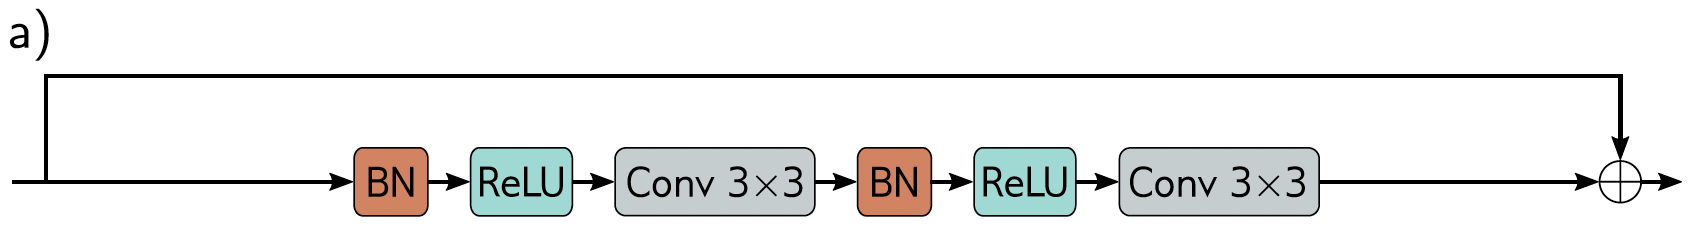

In [9]:
class NormalBlock(nn.Module):
    def __init__(self, in_channels:int = 64):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = in_channels, kernel_size = 3 , stride = 1, padding = 1)
        self.batch_norm1 = nn.BatchNorm2d(num_features = in_channels)
        self.conv2 = nn.Conv2d(in_channels = in_channels, out_channels = in_channels, kernel_size = 3 , stride = 1, padding = 1)
        self.batch_norm2 = nn.BatchNorm2d(num_features = in_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.activation(x)
        x = self.conv1(x)
        x = self.batch_norm2(x)
        x = self.activation(x)
        x = self.conv2(x)
        return x

In [10]:
m = NormalBlock()
m.to(device)
torchsummary.summary(m, input_size = (64,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1         [-1, 64, 256, 256]             128
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
       BatchNorm2d-4         [-1, 64, 256, 256]             128
              ReLU-5         [-1, 64, 256, 256]               0
            Conv2d-6         [-1, 64, 256, 256]          36,928
Total params: 74,112
Trainable params: 74,112
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 16.00
Forward/backward pass size (MB): 192.00
Params size (MB): 0.28
Estimated Total Size (MB): 208.28
----------------------------------------------------------------


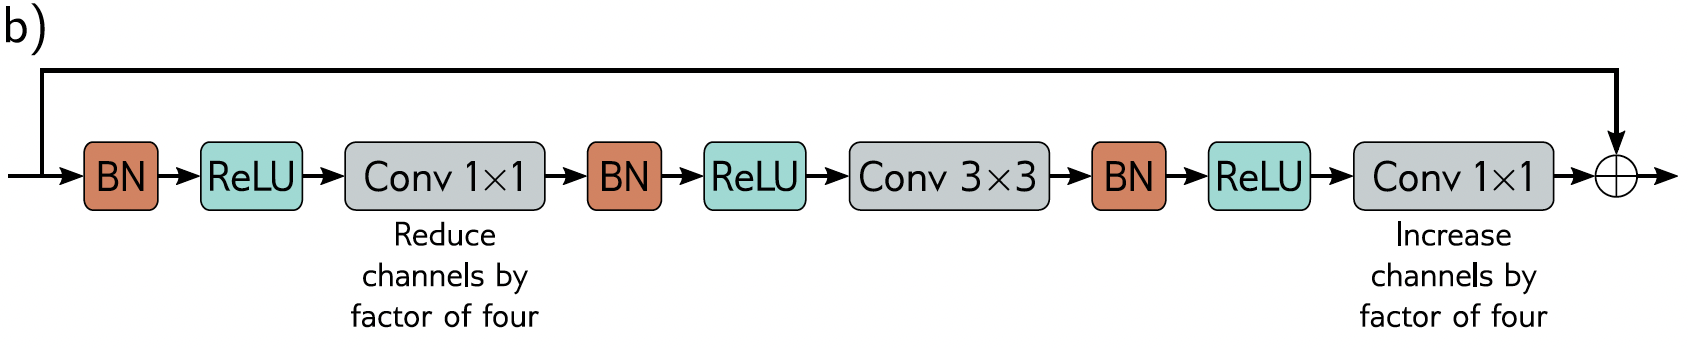

In [11]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels:int = 32):
        super().__init__()
        self.intermediate_channels = int(in_channels/4)
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = self.intermediate_channels, kernel_size = 1 , stride = 1, padding = 0)
        self.conv2 = nn.Conv2d(in_channels = self.intermediate_channels, out_channels = self.intermediate_channels, kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = self.intermediate_channels, out_channels = in_channels, kernel_size = 1 , stride = 1, padding = 0)
        self.batch_norm1 = nn.BatchNorm2d(num_features = in_channels)
        self.batch_norm2 = nn.BatchNorm2d(num_features = self.intermediate_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.activation(x)
        x = self.conv1(x)
        x = self.batch_norm2(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.activation(x)
        x = self.conv3(x)
        return x




In [12]:
m = BottleneckBlock()
m.to(device)
torchsummary.summary(m, input_size = (32,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1         [-1, 32, 256, 256]              64
              ReLU-2         [-1, 32, 256, 256]               0
            Conv2d-3          [-1, 8, 256, 256]             264
       BatchNorm2d-4          [-1, 8, 256, 256]              16
              ReLU-5          [-1, 8, 256, 256]               0
            Conv2d-6          [-1, 8, 256, 256]             584
       BatchNorm2d-7          [-1, 8, 256, 256]              16
              ReLU-8          [-1, 8, 256, 256]               0
            Conv2d-9         [-1, 32, 256, 256]             288
Total params: 1,232
Trainable params: 1,232
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 8.00
Forward/backward pass size (MB): 72.00
Params size (MB): 0.00
Estimated Total Size (MB): 80.00
---------------------------------------------

In [13]:
class PredictorHead(nn.Module):
    def __init__(self,in_dimensions: tuple[int, int, int] = (64,128,128), n_classes = 251):
        super().__init__()
        self.flatten = nn.Flatten()
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        flattened_dim = int(in_dimensions[0]*in_dimensions[1]*in_dimensions[2])
        self.layer1 = nn.Linear(flattened_dim, n_classes)
        self.layer2 = nn.Linear(n_classes, n_classes)

    def forward(self,x):
        x = self.flatten(x)
        x = self.layer1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer2(x)
        return x




In [14]:
m = PredictorHead(in_dimensions = (16,16,16))
m.to(device)
torchsummary.summary(m, input_size = (16,16,16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 4096]               0
            Linear-2                  [-1, 251]       1,028,347
              ReLU-3                  [-1, 251]               0
           Dropout-4                  [-1, 251]               0
            Linear-5                  [-1, 251]          63,252
Total params: 1,091,599
Trainable params: 1,091,599
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.04
Params size (MB): 4.16
Estimated Total Size (MB): 4.22
----------------------------------------------------------------


In [15]:
class ResNet(nn.Module):
    def __init__(self, in_channels = 3, int_channels = 32, n_blocks = 20, n_pools = 2,   block_type = "normal",  n_classes = 251):

        '''
        n_blocks/n_pools should be an integer, if it isnt the constructor will round it
        '''

        super().__init__()

        self.funnel = Funnel(in_channels = in_channels, out_channels = int_channels)

        self.n_pools = n_pools
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)




        self.body = nn.ModuleList([])
        blocks_per_pool = int(n_blocks/n_pools)

        if block_type == "bottleneck":
            for i in range(n_pools):
                for j in range(blocks_per_pool):
                    self.body.append(BottleneckBlock(in_channels = int_channels))
                self.body.append(self.pool)

        if block_type == "normal":
            for i in range(n_pools):
                for j in range(blocks_per_pool):
                    self.body.append(NormalBlock(in_channels = int_channels))
                self.body.append(self.pool)


        final_dimension = int(128/(2**n_pools))

        self.predictor = PredictorHead(in_dimensions = (int_channels,final_dimension,final_dimension),n_classes = n_classes)

    def forward(self,x):

        x = self.funnel(x)

        for block in self.body:
            if isinstance(block, nn.MaxPool2d):
                x = block(x)
            else:
                x = x + block(x)

        x = self.predictor(x)

        return x


In [16]:
m = ResNet(in_channels = 3, int_channels = 32, n_blocks = 20, n_pools = 4, block_type = "bottleneck",  n_classes = 251)
m.to(device)
torchsummary.summary(m, input_size = (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
              ReLU-2         [-1, 32, 256, 256]               0
         MaxPool2d-3         [-1, 32, 128, 128]               0
            Funnel-4         [-1, 32, 128, 128]               0
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              ReLU-6         [-1, 32, 128, 128]               0
            Conv2d-7          [-1, 8, 128, 128]             264
       BatchNorm2d-8          [-1, 8, 128, 128]              16
              ReLU-9          [-1, 8, 128, 128]               0
           Conv2d-10          [-1, 8, 128, 128]             584
      BatchNorm2d-11          [-1, 8, 128, 128]              16
             ReLU-12          [-1, 8, 128, 128]               0
           Conv2d-13         [-1, 32, 128, 128]             288
  BottleneckBlock-14         [-1, 32, 1

### 1.2.2 - Simple Cnn


In [17]:
class SimpleCnn(nn.Module):
    def __init__(self,  n_classes = 251):

        '''
        '''

        super().__init__()

        self.activation = nn.ReLU()
        #256
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3 , stride = 1, padding = 0)
        #254
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3 , stride = 1, padding = 0)
        #252
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        #126
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3 , stride = 1, padding = 0)
        #124
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3 , stride = 1, padding = 0)
        #122
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3 , stride = 1, padding = 0)
        #120
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        #60
        self.conv6 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3 , stride = 1, padding = 0)
        #58
        self.conv7 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3 , stride = 1, padding = 0)
        #56
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        #28
        self.conv8 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3 , stride = 1, padding = 0)
        #26
        self.conv9 = nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 3 , stride = 1, padding = 0)
        #24
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        #12
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.2)
        self.layer1 = nn.Linear(12*12*16, n_classes)
        self.layer2 = nn.Linear(n_classes, n_classes)



    def forward(self,x):

        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.activation(x)
        x = self.conv4(x)
        x = self.activation(x)
        x = self.conv5(x)
        x = self.activation(x)
        x = self.pool(x)
        x = self.conv6(x)
        x = self.activation(x)
        x = self.conv7(x)
        x = self.activation(x)
        x = self.pool(x)
        x = self.conv8(x)
        x = self.activation(x)
        x = self.conv9(x)
        x = self.activation(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.layer1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer2(x)

        return x

In [18]:
m = SimpleCnn()
m.to(device)
torchsummary.summary(m, input_size = (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 254, 254]             448
              ReLU-2         [-1, 16, 254, 254]               0
            Conv2d-3         [-1, 32, 252, 252]           4,640
              ReLU-4         [-1, 32, 252, 252]               0
         MaxPool2d-5         [-1, 32, 126, 126]               0
            Conv2d-6         [-1, 64, 124, 124]          18,496
              ReLU-7         [-1, 64, 124, 124]               0
            Conv2d-8         [-1, 64, 122, 122]          36,928
              ReLU-9         [-1, 64, 122, 122]               0
           Conv2d-10         [-1, 64, 120, 120]          36,928
             ReLU-11         [-1, 64, 120, 120]               0
        MaxPool2d-12           [-1, 64, 60, 60]               0
           Conv2d-13           [-1, 64, 58, 58]          36,928
             ReLU-14           [-1, 64,

## **1.4** - systems

In [19]:
class CnnImageClassification(L.LightningModule):

    def __init__(self, model, loss_module, optimizer_name: str , optimizer_hparams):
        super().__init__()
        self.model = model
        self.loss_module = loss_module
        self.optimizer_name = optimizer_name
        self.optimizer_hparams = optimizer_hparams
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        if self.optimizer_name == "Adam":
            optimizer = torch.optim.Adam(self.parameters(), **self.optimizer_hparams)
        elif self.optimizer_name == "SGD":
            optimizer = torch.optim.SGD(self.parameters(), **self.optimizer_hparams)

        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss_module(y_hat, y)

        acc = (y_hat.argmax(dim=-1) == y).float().mean()

        self.log("train_acc", acc, on_step=False, on_epoch=True)
        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self.model(x).argmax(dim=-1)
        acc = (y == preds).float().mean()

        self.log("val_acc", acc, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y= batch
        preds = self.model(x).argmax(dim=-1)
        acc = (y == preds).float().mean()


        self.log("test_acc", acc)




## **1.5** - model evaluation

Accuracy	[0, 1]	Proportion of correct predictions
Precision	[0, 1]	Fraction of true positives out of predicted positives
Recall	[0, 1]	Fraction of true positives out of actual positives
F1-Score	[0, 1]	Harmonic mean of precision and recall
AUC-ROC	[0, 1]	Area under the ROC curve
AUC-PR

# **2 - script 🔥**

## **2.1** - data

### 2.1.1 - data download and preparation

In [20]:
data_urls = {
    "annotations": "https://food-x.s3.amazonaws.com/annot.tar",
    "training_images": "https://food-x.s3.amazonaws.com/train.tar",
    "validation_images": "https://food-x.s3.amazonaws.com/val.tar"
}

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # ImageNet Normalisation
])



my_data = MyDataModule(data_urls = data_urls, transform = transform, batch_size_train = 128)


In [ ]:
my_data.prepare_data()

In [21]:
my_data.setup()

### 2.1.2 - visualisation

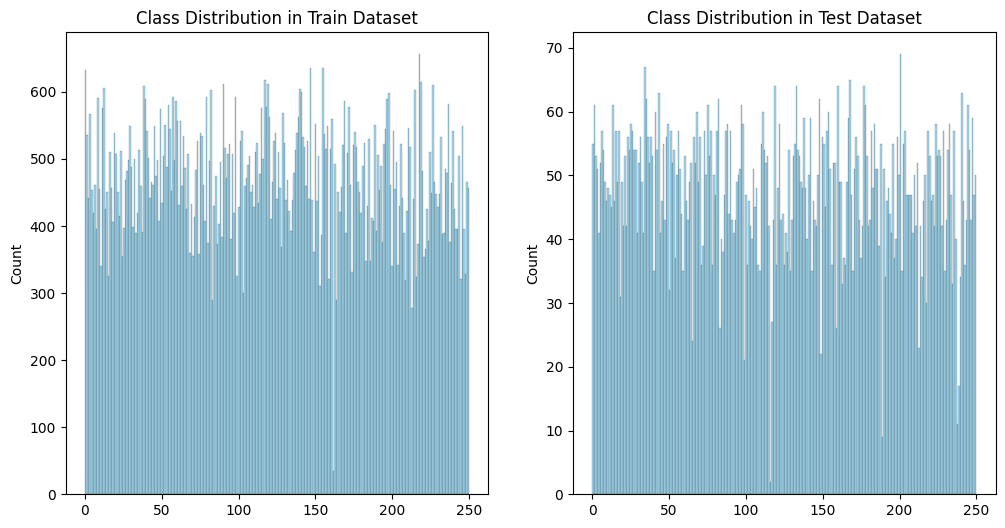

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(my_data.train_val_labels,
    kde=False,
    bins=len(np.unique(my_data.train_val_labels)),
    color='skyblue',
    ax=axes[0]
)

axes[0].set_title('Class Distribution in Train Dataset')


sns.histplot(my_data.test_labels,
    kde=False,
    bins=len(np.unique(my_data.test_labels)),
    color='skyblue',
    ax=axes[1]
)



axes[1].set_title('Class Distribution in Test Dataset')

plt.show()

del fig, axes




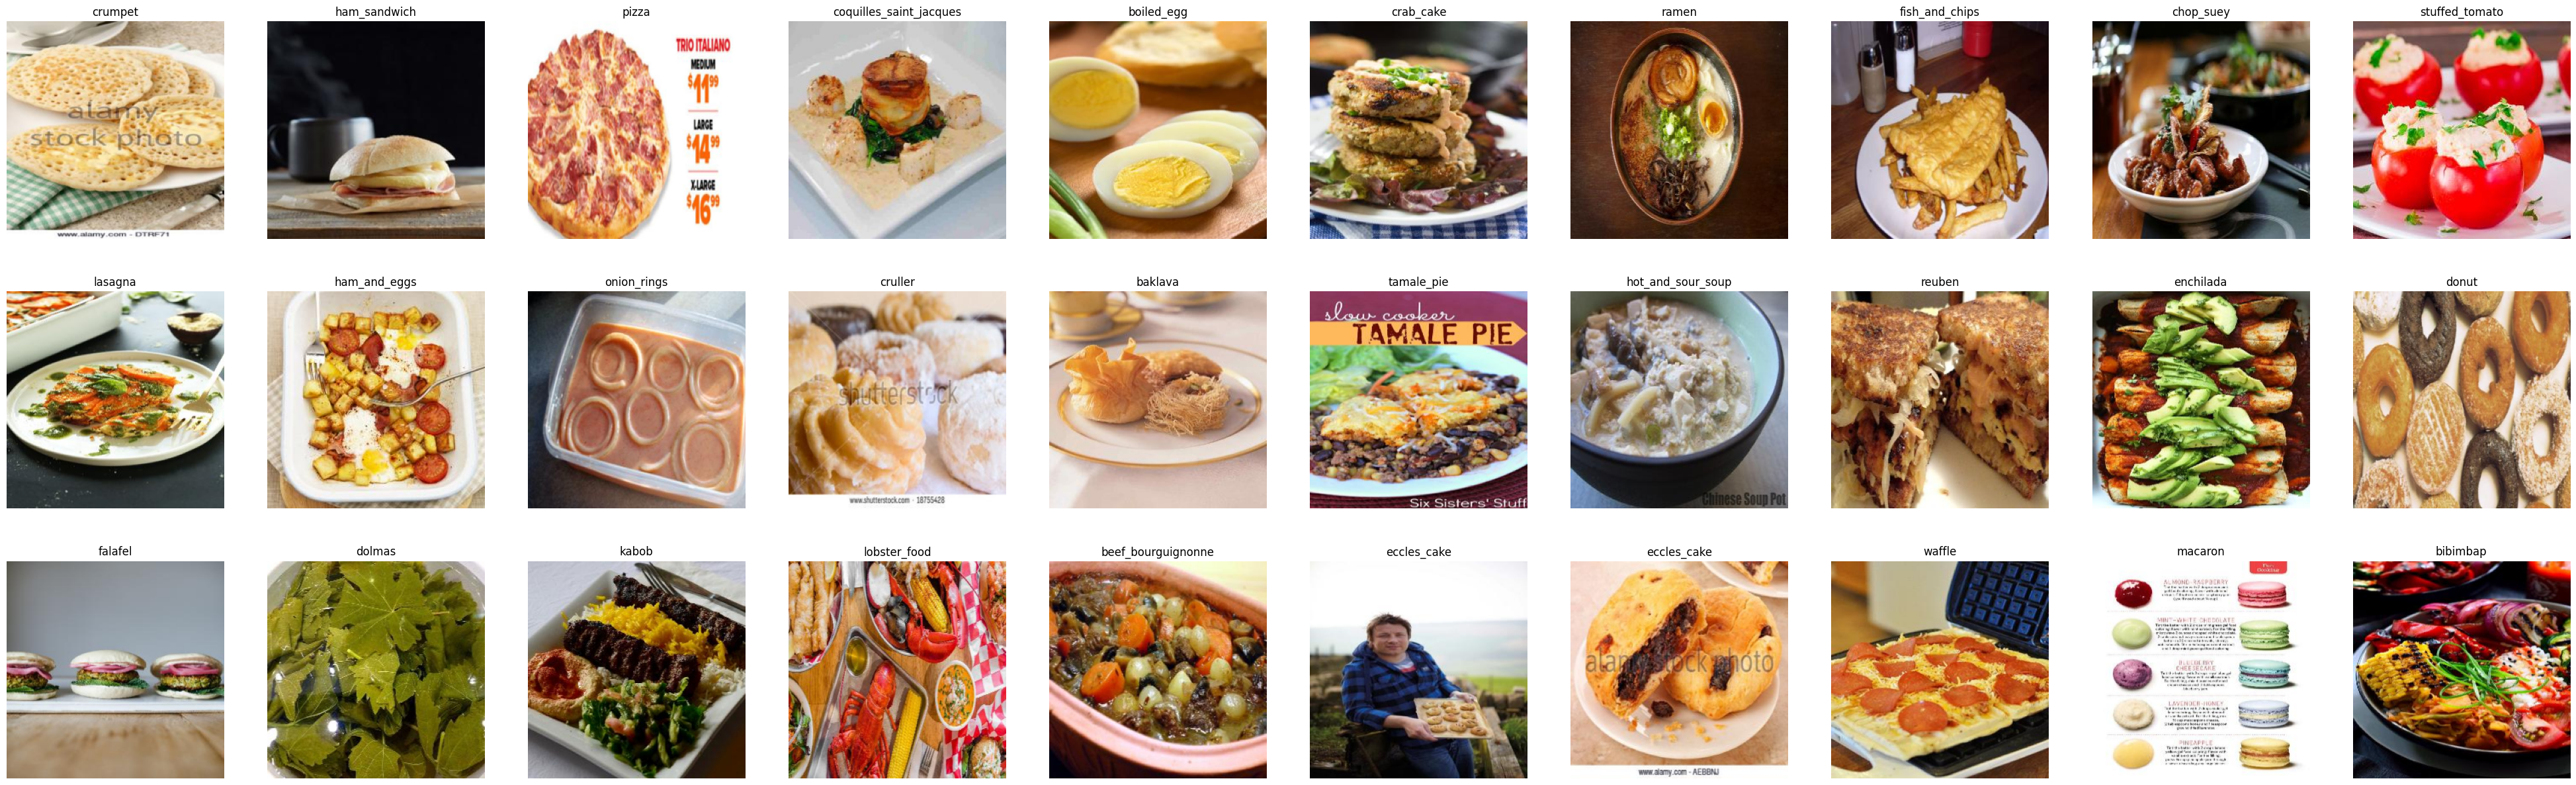

In [40]:
my_data.visualise_some_images(n=30)

In [ ]:
directory = 'train_features/descriptors/'

for file_name in tqdm(os.listdir(directory)):
        full_path = os.path.join(directory, file_name)
        des = np.load(full_path, allow_pickle=True)

        if len(des.shape) != 2:
            print(full_path)
            print(des)
            des.shape

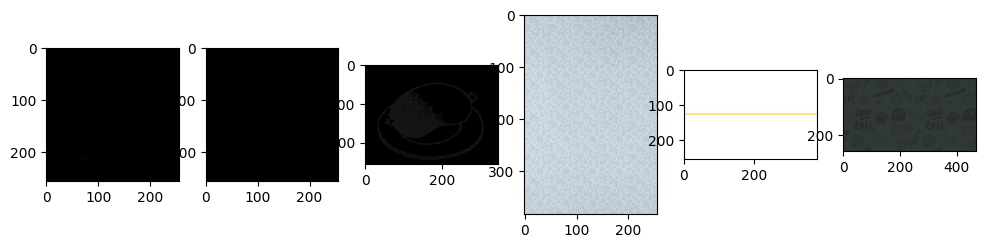

In [46]:
# the null images i found
images = ['train_085645', 'train_059868', 'train_031740', 'train_012823','train_115882', 'train_094869' ]

fig, axes = plt.subplots(1, 6, figsize=(12, 6))

for i, image in enumerate(images):

    image_path = "train_set/"+image+".jpg"
    img = mpl.image.imread(image_path)
    axes[i].imshow(img)

plt.show()

### 2.1.3 - feature extraction using sift and bag of words

In [ ]:
my_data.extract_sift_features()

In [22]:
my_data.setup_sift_datasets()


In [23]:
my_data.extract_bow_features()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

## **2.2** - Traditional Classifiers

In [ ]:
def train_and_eval_traditional(config = None, model_str = "_", ModelClass= None, data_module = my_data):
    with wandb.init(config=config):
        config = wandb.config

        #obtain the data
        X_train = data_module.train_bow
        y_train = data_module.train_labels
        X_val =  data_module.val_bow
        y_val =  data_module.val_labels

        #initialise the model
        model = ModelClass(**config['parameters'])
        #train
        model.fit(X_train,y_train)


        #compute predictions
        y_pred = model.predict(X_val)


        # Calculate evaluation metrics
        accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)
        precision = sklearn.metrics.precision_score(y_val, y_pred, average='micro')
        recall = sklearn.metrics.recall_score(y_val, y_pred, average='micro')
        f1 = sklearn.metrics.f1_score(y_val, y_pred, average='micro')


        wandb.log({
            "val_acc": accuracy,
            "val_precision": precision,
            "val_recall": recall,
            "val_f1": f1
        })

        #save the best model for later
        if accuracy > wandb.run.summary.get("best_accuracy", 0):

            wandb.run.summary["best_accuracy"] = accuracy
            model_filename = "best_" + model_str + ".joblib"
            joblib.dump(model, model_filename)

            model_artifact = wandb.Artifact("best_" + model_str, type='model')
            model_artifact.add_file(model_filename)
            wandb.log_artifact(model_artifact)


2.2.1 - Support Vector Machines (SVMs)

In [ ]:
sweep_config = {
    'method' : 'grid',
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'C': {
            'values': [0.001, 0.01, 0.1, 1, 10, 100]
        },
        'kernel': {
            'values': ['linear', 'poly', 'rbf', 'sigmoid']
        },
        'gamma': {
            'values' : ['scale', 'auto', 0.001, 0.01, 0.1, 1]
        },
        'class_weight': {
            'value': 'balanced'
        }
    }

}

wandb.login()
sweep_id = wandb.sweep(sweep_config, project="supervised_learning_fp")
wandb.agent(sweep_id, function=train_and_eval_traditional(ModelClass = sklearn.svm.SVC, data_module = my_data))

2.2.2 - k-Nearest Neighbors (k-NN)

In [ ]:
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'n_neighbors': {
            'values': [3, 5, 7, 9, 11, 15, 20, 25, 30, 40, 50]
        },
        'weights': {
            'values': ['uniform', 'distance']
        },
        'p': {
            'values' : [1, 2]
        }
    }
}

wandb.login()
sweep_id = wandb.sweep(sweep_config, project="supervised_learning_fp")
wandb.agent(sweep_id, function=train_and_eval_traditional(ModelClass = sklearn.neighbors.KNeighborsClassifier, data_module = my_data))

2.2.3 - MLP *

In [ ]:
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'hidden_layer_sizes': {
            'values': [(50,20),]
        },
        'activation': {
            'value': 'relu'
        },
        'solver': {
            'value' : 'adam'
        },
        'learning_rate_init': {
            'values': [0.0001, 0.001, 0.01]
        },
        'early_stopping': {
            'value': True
        }

    }

}

wandb.login()
sweep_id = wandb.sweep(sweep_config, project="supervised_learning_fp")
wandb.agent(sweep_id, function=train_and_eval_traditional(ModelClass = sklearn.neural_network.MLPClassifier, data_module = my_data))

2.2.4 - Random Forests

In [ ]:
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'n_estimators': {
            'values': [100, 1000]
        },
        'criterion': {
            'values': ['gini', 'entropy']
        },
        'max_features': {
            'values' : [ 0.001, 0.01, 0.1, 0.5, 0.9]
        },
        'min_samples_leaf': {
            'values' : [ 1, float(1/251)]
        }
    }

}

wandb.login()
sweep_id = wandb.sweep(sweep_config, project="supervised_learning_fp")
wandb.agent(sweep_id, function=train_and_eval_traditional(ModelClass = sklearn.ensemble.RandomForestClassifier, data_module = my_data))

2.2.5 - Adaboost

In [ ]:
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'n_estimators': {
            'values': [10, 100, 1000]
        },
        'learning_rate': {
            'values': [1, 5]
    }
}

wandb.login()
sweep_id = wandb.sweep(sweep_config, project="supervised_learning_fp")
wandb.agent(sweep_id, function=train_and_eval_traditional(ModelClass = sklearn.ensemble.AdaBoostClassifier, data_module = my_data))

## **2.3** - cnn

In order to experiment with a custom neural architecture I will start from a resnet model and explore some hyperparameter combinations. First, I will consider two types of residual blocks: normal and bottleneck. Then, I will consider different number of intermediate channels and pooling operation throughout the network. The number of intermediate channel and the number of pooling operations will be linked by the necessity to maintain ~500k parameters in the first linear layer.

In particular the governing equation will be $int\_channels = \frac{2^{2 n\_pools}}{2^3}$


In [ ]:
n_pools_list = [3,4,5,6]

for n_pools in n_pools_list:
    int_channels = 2**(2*n_pools)/2**3
    dim = 128/(2**n_pools)
    tot_features = int_channels*dim*dim
    print(f"int_channels: {int_channels}, n_pools: {n_pools}, dim: {dim}, tot_features:{tot_features}")

int_channels: 8.0, n_pools: 3, dim: 16.0, tot_features:2048.0
int_channels: 32.0, n_pools: 4, dim: 8.0, tot_features:2048.0
int_channels: 128.0, n_pools: 5, dim: 4.0, tot_features:2048.0
int_channels: 512.0, n_pools: 6, dim: 2.0, tot_features:2048.0


In [ ]:
def train_and_eval(config = None, datamodule=my_data):
    with wandb.init(config=config):
        config = wandb.config

        int_channels = int(2**(2*config.n_pools)/2**3)

        if config.net_type == "simple_cnn":
            model = SimpleCnn(n_classes = 251)
        elif config.net_type == "resnet":
            model = ResNet(in_channels = 3, int_channels = int_channels, n_blocks = 20, n_pools = config.n_pools, block_type = config.block_type,  n_classes = 251)

        system = CnnImageClassification(model = model, loss_module = nn.CrossEntropyLoss(), optimizer_name = "Adam", optimizer_hparams = {"lr": 0.001})

        wandb_logger = L.pytorch.loggers.WandbLogger(project='resnet_architecture_experiment', job_type='train')
        checkpoint_callback = L.callbacks.ModelCheckpoint(
            monitor="val_loss",
            mode="min",
            save_top_k=1,
            save_weights_only=False,
            verbose=True
        )
        early_stopping = L.callbacks.EarlyStopping(
            monitor="val_loss",
            mode="min",
            patience=2,
            verbose=True
        )

        trainer = L.pytorch.Trainer(max_epochs=config.n_epochs, logger=wandb_logger, callbacks=[checkpoint_callback, early_stopping])

        trainer.fit(system, datamodule=my_data)

        trainer.validate(system, datamodule=my_data)




In [ ]:
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'net_type': {
            'value': "simple_cnn"
        },
        'n_epochs': {
            'value': 50
        }
    }

}

wandb.login()
sweep_id = wandb.sweep(sweep_config, project="supervised_learning_fp")
wandb.agent(sweep_id, function=train_and_eval)


In [ ]:
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'net_type': {
            'values': ["resnet"]
        },
        'block_type': {
            'values': ["normal", "bottleneck"]
        },
        'n_pools': {
            'values': [3,4,5,6]
        },
        'n_epochs': {
            'value': 50
        }
    }

}

wandb.login()
sweep_id = wandb.sweep(sweep_config, project="supervised_learning_fp")
wandb.agent(sweep_id, function=train_and_eval)



Create sweep with ID: eit4dsk0
Sweep URL: https://wandb.ai/dan_mon_uni-uni/supervised_learning_fp/sweeps/eit4dsk0


wandb: Agent Starting Run: bpjgj4bp with config:
wandb: 	block_type: normal
wandb: 	n_epochs: 50
wandb: 	n_pools: 3


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss_module' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_module'])`.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


rm: cannot remove 'sample_data': No such file or directory
mv: cannot move 'val_set' to 'test_set/val_set': Directory not empty


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | model       | ResNet           | 599 K  | train
1 | loss_module | CrossEntropyLoss | 0      | train
---------------------------------------------------------
599 K     Trainable params
0         Non-trainable params
599 K     Total params
2.397     Total estimated model params size (MB)
122       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name        | Type             | Params | Mode 
----------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
wandb.finish()

## **2.4** - ssl

## **2.5** - model evaluation

## **2.6** - hyperparameter tuning